In [1]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Détection avion par ML

On utilise pytorch ainsi que YOLO v8 (https://github.com/ultralytics/ultralytics)

Le data set : https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset

# -----------------------------------

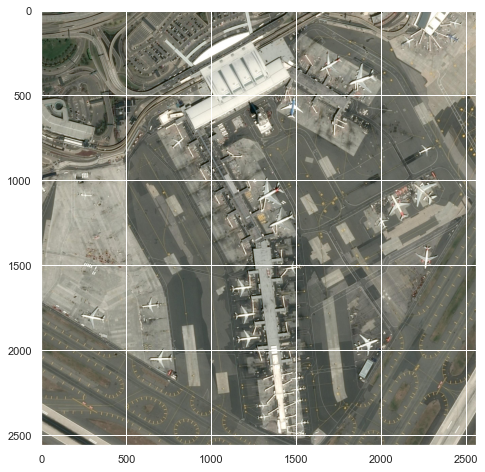

In [38]:
# Ouverture image aleatoire du dataset

import glob
img_list = glob.glob("./images/*")
pickone = random.choice(img_list)
img = plt.imread(pickone)

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [24]:
print(f"Il y a {len(img_list)} images dans le dataset")
print(f"Dimension images: {img.shape}")

Il y a 103 images dans le dataset
Dimension images: (2560, 2560, 3)


In [5]:
# Création de tableau avec les labels 

df = pd.read_csv('annotations.csv')
# convert a string record into a valid python object
def f(x): 
    return ast.literal_eval(x.rstrip('\r\n'))

df = pd.read_csv("annotations.csv", converters={'geometry': f})
df.head(10)

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane


In [25]:
# Réarangement du tableau des labels

def creation_bounding_box(geom):
    geom = np.array(geom).T
    
    xmin = np.min(geom[0])
    ymin = np.min(geom[1])
    xmax = np.max(geom[0])
    ymax = np.max(geom[1])
    
    bb = (xmin, ymin, xmax, ymax)
    width = xmax - xmin
    height = ymax - ymin
    
    return(bb, width, height)

df[["bounds","width", "height"]] = df.apply(lambda x: creation_bounding_box(x.geometry), axis=1, result_type="expand")
df.head()

,id,image_id,geometry,class,bounds,width,height
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane,"(135, 522, 245, 600)",110,78
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane,"(1025, 284, 1125, 384)",100,100
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane,"(1058, 1503, 1130, 1568)",72,65
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane,"(813, 1518, 885, 1604)",72,86
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane,"(594, 938, 657, 1012)",63,74


In [8]:
# Separation des données en liste d'entraienemnt et de validation

fold = 1
num_fold = 5
index = df['image_id'].unique()
val_indexes = index[len(index)*fold//num_fold:len(index)*(fold+1)//num_fold]
print(val_indexes)

['78099b50-f2b6-4319-b462-f33df2966c45.jpg'
 '22291e0b-ebe2-4f3f-b53e-4e709179300a.jpg'
 'cc4f3226-c262-409e-a4b2-a576e776f7f4.jpg'
 '34ae857d-6e71-46b9-b694-d9e40fb093bc.jpg'
 '5c9e817a-dc4b-42ab-952c-3128e2de12e8.jpg'
 'af67041b-f363-47ae-8ddd-f652db3a6bab.jpg'
 '0263270b-e3ee-41dc-aeef-43ff77e66d5b.jpg'
 'd8873734-016a-4b9d-9b9e-8bc47eb13fef.jpg'
 'd0c3d270-f23e-4792-bac0-142a9cc8ccc6.jpg'
 '78400c58-1a7c-4342-a1fb-2117cb7cbc8b.jpg'
 '77f7b57f-5cf2-424d-a952-9847b3c3f35e.jpg'
 'd9399a45-6745-4e59-8903-90640b2ddf9f.jpg'
 '014de911-7810-4f7d-8967-3e5402209f4a.jpg'
 'd3d2b706-9017-41f4-b57e-469038daa634.jpg'
 '4c9d2482-788c-4d68-a3d4-478b2367abce.jpg'
 '576827bc-a94a-4611-8820-f3d56e969151.jpg'
 '4e9164aa-532e-4b76-bce4-060b090da357.jpg'
 '14436c8c-93ec-41af-9fbf-43a5f39f2b98.jpg'
 '7635d63c-6b97-4c9c-a7dc-27773d42ed4c.jpg'
 'ecfe7982-05e5-435f-824b-e24b6846316e.jpg'
 '8df07836-4606-446e-9880-6ed9e0f74543.jpg']


In [9]:
import os 
import tqdm.notebook

# Redécoupage des images en 512x512*3 plutot que 2560*2560*3 avec un overlap de 64px

TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

IMAGE_WIDTH = 2560
IMAGE_HEIGHT = 2560


# Création folders
TILES_DIR = {'train': Path('./inputs/train/images/'),
             'val': Path('./inputs/val/images/')}

for _, folder in TILES_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

LABELS_DIR = {'train': Path('./inputs/train/labels/'),
              'val': Path('./inputs/val/labels/')}

for _, folder in LABELS_DIR.items():
    if not os.path.isdir(folder):
        os.makedirs(folder)

        
# Création du .txt des labels correspondant aux images
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None
    
    x_max_trunc = min(x_max, width) 
    x_min_trunc = max(x_min, 0) 
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, width) 
    y_min_trunc = max(y_min, 0) 
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None
        
    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height
    
    return (0, x_center, y_center, x_extend, y_extend)
            
for img_path in tqdm.notebook.tqdm(img_list):
    # Ouvre l'image
    pil_img = PIL.Image.open(img_path, mode='r')
    np_img = np.array(pil_img, dtype=np.uint8)

    # Annotation de l'image
    img_labels = df[df["image_id"] == img_path.split("\\")[-1]]
    #print(img_path.split("\\")[-1], img_labels)

    # Cmpte le nombre de tuile à creer 
    X_TILES = (IMAGE_WIDTH + TILE_WIDTH + TILE_OVERLAP - 1) // TILE_WIDTH 
    Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT + TILE_OVERLAP - 1) // TILE_HEIGHT
    
    # Création des tuiles
    for x in range(X_TILES):
        for y in range(Y_TILES):

            x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
            x_start = x_end - TILE_WIDTH
            y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
            y_start = y_end - TILE_HEIGHT
            #print(x_start, y_start)

            folder = 'val' if Path(img_path).name in val_indexes else 'train'
            save_tile_path = TILES_DIR[folder].joinpath(Path(img_path).stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
            save_label_path = LABELS_DIR[folder].joinpath(Path(img_path).stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")
                
            if _overwriteFiles or not os.path.isfile(save_tile_path):
                cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                cut_tile_img = PIL.Image.fromarray(cut_tile)
                cut_tile_img.save(save_tile_path)

            found_tags = [
                tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                for i, bounds in enumerate(img_labels['bounds'])]
            found_tags = [el for el in found_tags if el is not None]

            with open(save_label_path, 'w+') as f:
                for tags in found_tags:
                    f.write(' '.join(str(x) for x in tags) + '\n')

  0%|          | 0/103 [00:00<?, ?it/s]

In [10]:
# Création du fichier de config pour Yolo v8

CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: C:/Users/Adrien/Desktop/Python_Project/Airbus_detection/inputs/train/
val: C:/Users/Adrien/Desktop/Python_Project/Airbus_detection/inputs/val/

# number of classes
nc: 1

# class names
names: ['Aircraft']
"""

with open("data.yaml", "w") as f:
    f.write(CONFIG)

# Dans le CLI on lance l'entrainement des données avec le modèle S de YOLO v8

`!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=10 imgsz=512`

<function matplotlib.pyplot.show(*, block=None)>

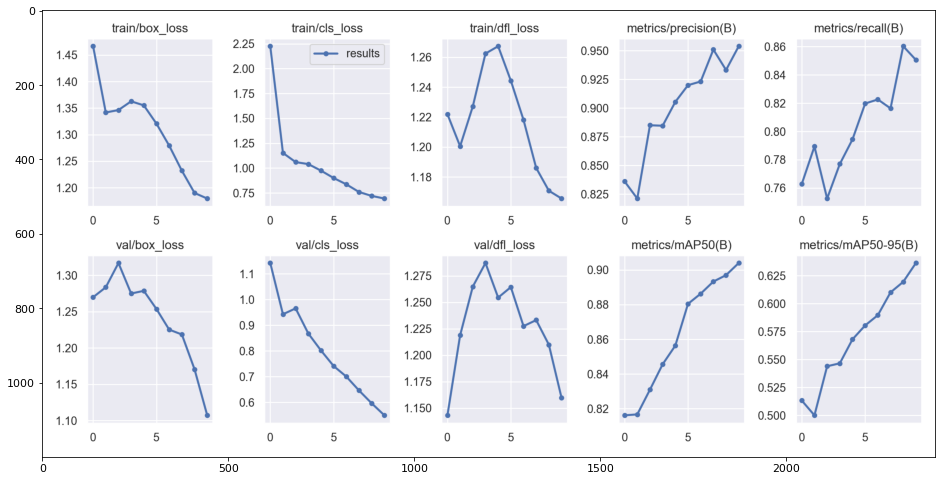

In [28]:
plt.figure(figsize=(16, 16))
img = plt.imread("./runs/detect/train3/results.png")
plt.imshow(img)
plt.show

In [ ]:
# Verification

Ultralytics YOLOv8.0.55  Python-3.10.2 torch-1.13.1+cu116 CUDA:0 (GeForce GTX 1650 with Max-Q Design, 4096MiB)
val: Scanning C:\Users\Adrien\Desktop\Python_Project\Airbus_detection\inputs\val\labels.cache... 756 images, 273 backgr
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:31
                   all        756       1459      0.939      0.865      0.904      0.636
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\val


image 1/1 C:\Users\Adrien\Desktop\Python_Project\Airbus_detection\test5.jpg: 512x512 4 Aircrafts, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


<function matplotlib.pyplot.show(*, block=None)>

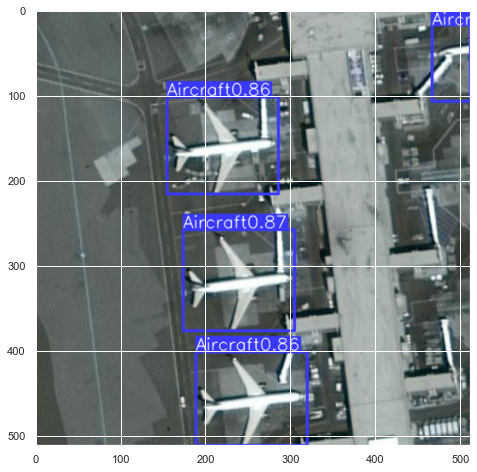

In [39]:
# Auto test 

model_aircraft = YOLO("./runs/detect/train3/weights/best.pt")
res = model_aircraft("test5.jpg")
res_plotted = res[0].plot()
plt.figure(figsize=(8, 8))
plt.imshow(res_plotted)
plt.show